# Exploring Sentiments Toward AI in Film and Media Creation Across Social Media Platforms

**Project Author**: Dominique Akinyemi

**Date**: December 16th, 2024

## **Introduction**

Artificial intelligence (AI) has made significant strides in the creative industries, transforming how we approach filmmaking, screenwriting, and visual media production. From generative AI tools that craft scripts to deepfake technologies that manipulate visuals, the impact of AI in creative storytelling is undeniable. But how do filmmakers, screenwriters, and audiences feel about this technological revolution?

This project aims to uncover the sentiments and emotions surrounding AI’s use in the film and media industry. By analyzing conversations across Twitter, Reddit, and YouTube, I will delve into how different groups perceive AI's potential, its risks, and its role in reshaping the art of storytelling. Leveraging advanced sentiment and emotion analysis tools, this project seeks to illuminate the hopes and fears embedded in these discussions.

Through this exploration, we gain insight into the public's response to generative AI’s presence in one of the most human-driven creative domains: the art of making movies and stories.

### Tools:
- Programming: Python
- Libraries: Pandas, Matplotlib, Seaborn, NRCLex, NLTK
- APIs: Twitter/X, YouTube, Reddit
- Data Collection: Web scraping with PRAW and Google API
- Sentiment Analysis: TextBlob, Hugging Face Transformers (pre-trained model)
- Visualization: Matplotlib, Seaborn, wordcloud

### Objectives:
1. Analyze sentiment and emotional responses to AI in filmmaking, screenwriting, and media creation.
2. Compare sentiment trends across Twitter, Reddit, and YouTube, highlighting platform-specific perspectives.
3. Identify levels of excitement, fear, trust, and skepticism in public discourse.
4. Provide insights into public perceptions of generative AI's role in reshaping storytelling.

### Challenges:
1. Imbalanced data volumes across platforms, requiring normalization for fair comparison.
2. Platform-specific text preprocessing needs to account for differences in formatting and language use.
3. API rate limitations impose constraints on the quantity of data collected.
4. Twitter/X data is limited to 100 tweets due to free API restrictions, making it a supplementary rather than a primary dataset.

## **Section 1: Data Collection**

This section describes the process of gathering data from Twitter, Reddit, and YouTube to analyze public sentiment and emotions regarding AI's role in film and media creation. APIs and scraping tools were used to collect relevant discussions based on keywords such as "AI filmmaking," "AI screenwriting," and "generative AI." Each platform offered unique perspectives and user groups, contributing to a holistic analysis.

In [2]:
# Loaded libraries that will be used for scraping data
import pandas as pd
import tweepy
import praw
from googleapiclient.discovery import build
import time

### **Twitter/X Data Collection**

X currently allows developers to scrape 100 posts a month without paying for access, which limited the amount of data from this platform.

In [ ]:
# Set up X API credentials and authenticated with Tweepy
bearer_token = "token"
client = tweepy.Client(bearer_token=bearer_token)

# Defined the search query
query = "AI movies -is:retweet"

# Fetched tweets and extracted data
tweets = client.search_recent_tweets(query=query, max_results=100, tweet_fields=["created_at", "text", "author_id"])

tweets_data = []

for tweet in tweets.data:
    tweets_data.append([tweet.id, tweet.created_at, tweet.text, tweet.author_id])

tweets_df = pd.DataFrame(tweets_data, columns=["Tweet_ID", "Created_At", "Text", "Author_ID"])

# Saved data to CSV
tweets_df.to_csv("ai_movies_tweets.csv", index=False)
print(f"Data saved to ai_movies_tweets.csv")

### **Reddit Data Collection**

Reddit has a 60-post-per-minute API limit, so this code is set to sleep for a minute after fetching posts. This allows the scraping to continue without stalling or getting stuck in a loop.

In [ ]:
# Initialized PRAW
reddit = praw.Reddit(
    client_id="id",
    client_secret="secret",
    user_agent="doms_reddit_scraper"
)

# Defined search queries
queries = {
    "movies": ["AI"],
    "filmmakers": ["AI"],
    "Screenwriting": ["AI"],
    "aiArt": ["filmmaking", "filmmakers", "films", "movies", "screenwriting", "AI creativity", "AI-generated scripts"],
    "artificial": ["filmmaking", "filmmakers", "films", "movies", "screenwriting", "entertainment", "media", "creativity", "content creation"],
    "ArtificialInteligence": ["filmmaking", "filmmakers", "films", "movies", "screenwriting", "entertainment", "media", "creativity", "content creation"],
    "OpenAI": ["filmmaking", "filmmakers", "films",  "movies", "entertainment", "screenwriting", "media", "creativity", "content creation"],
    "technology": ["AI filmmaking", "AI movies", "AI-generated", "AI screenwriting"]
}

#Fetched reddit posts and comments
def scrape_reddit_with_pagination(queries, posts_per_query=60, total_posts=1000):
    reddit_data = []
    seen_posts = set()

    for subreddit, keywords in queries.items():
        for keyword in keywords:
            print(f"Searching for '{keyword}' in r/{subreddit}...")
            count = 0
            after = None
            
            while count < total_posts:
                try:
                    search_results = reddit.subreddit(subreddit).search(
                        query=keyword,
                        sort="new",
                        limit=posts_per_query,
                        params={"after": after}
                    )
                    
                    new_posts = 0

                    for submission in search_results:
                        if submission.id in seen_posts:
                            continue

                        seen_posts.add(submission.id)
                        reddit_data.append({
                            'subreddit': subreddit,
                            'title': submission.title,
                            'text': submission.selftext,
                            'score': submission.score,
                            'id': submission.id,
                            'url': submission.url,
                            'created_at': submission.created_utc
                        })
                        after = submission.id
                        new_posts += 1

                    count += new_posts
                    print(f"Fetched {new_posts} new posts. Total: {count}/{total_posts}.")

                    if new_posts == 0:
                        print(f"No new posts for query '{keyword}' in r/{subreddit}. Moving to next query.")
                        break

                    time.sleep(60)  

                except praw.exceptions.RedditAPIException as api_error:
                    print(f"Reddit API error: {api_error}. Skipping '{keyword}' in r/{subreddit}.")
                    break
                except Exception as e:
                    print(f"Error: {e}. Waiting before retrying...")
                    time.sleep(120)
                    break 

    return reddit_data

reddit_posts = scrape_reddit_with_pagination(queries, posts_per_query=60, total_posts=500)

# Saved data to CSV
reddit_posts_df = pd.DataFrame(reddit_posts)
reddit_posts_df.to_csv('reddit_posts.csv', index=False)
print(f"Data saved to reddit_posts.csv")

### **Youtube Data Collection**

These functions search Youtube for videos containing the keywords defined as "queries." It returns comments for these videos, skipping videos with no comments or disabled comments.

In [ ]:
# Initialized YouTube API
api_key = "key"
youtube = build("youtube", "v3", developerKey=api_key)

# Defined search queries
queries = ["AI filmmaking", "AI in movies", "AI creativity", "AI media technology", "AI content creation"]

# Fetched comments from videos
def get_videos(query, max_results=20):
    request = youtube.search().list(
        q=query,
        part="id,snippet",
        type="video",
        maxResults=max_results
    )
    response = request.execute()
    video_data = [
        {
            "video_id": item["id"]["videoId"],
            "video_title": item["snippet"]["title"],
            "video_published_at": item["snippet"]["publishedAt"]
        }
        for item in response.get("items", [])
    ]
    return video_data

def get_comments(video_id, max_results=100):
    comments = []
    try:
        request = youtube.commentThreads().list(
            part="snippet",
            videoId=video_id,
            maxResults=max_results,
            textFormat="plainText"
        )
        while request:
            response = request.execute()
            for item in response.get("items", []):
                comment = item["snippet"]["topLevelComment"]["snippet"]
                comments.append({
                    "comment_id": item["id"],
                    "video_id": video_id,
                    "comment_text": comment["textDisplay"],
                    "comment_likes": comment["likeCount"],
                    "comment_published_at": comment["publishedAt"]
                })
            request = youtube.commentThreads().list_next(request, response)
    except Exception as e:
        print(f"Skipping video ID {video_id}: {e}")
    return comments

def fetch_youtube_data(queries, max_videos=20, max_comments=100):
    all_comments = []

    for query in queries:
        print(f"Searching videos for query: {query}")
        video_data = get_videos(query, max_results=max_videos)
        for video in video_data:
            print(f"Fetching comments for video: {video['video_title']} (ID: {video['video_id']})")
            comments = get_comments(video["video_id"], max_results=max_comments)
            for comment in comments:
                comment.update({
                    "video_title": video["video_title"],
                    "video_published_at": video["video_published_at"]
                })
            all_comments.extend(comments)
    
    return all_comments

yt = fetch_youtube_data(queries, max_videos=20, max_comments=100)

# Saved data to CSV
yt = pd.DataFrame(yt)
yt.to_csv("youtube_comments.csv", index=False)
print(f"Saved {len(yt)} comments to youtube_comments.csv")

## **Section 2: Exploratory Data Analysis**

In this section, some basic analyses were performed to examine the data distribution, inspect missing values, and identify recurring patterns or themes before cleaning and pre-processing.

In [49]:
# Loaded visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
# Loaded CSVs with scraped data
tweets = pd.read_csv("ai_movies_tweets.csv")
youtube = pd.read_csv("youtube_comments.csv")
reddit = pd.read_csv("reddit_posts.csv")

In [ ]:
# Displayed basic information about each dataset
def explore_data(df, name):
    print(f"--- {name} Dataset ---")
    print("Shape:", df.shape)
    print("Columns:", df.columns)
    print("Missing Values:\n", df.isnull().sum())
    print("Sample Rows:\n", df.head())
    print("\n")

# Examined all datasets
explore_data(tweets, "Twitter")
explore_data(reddit, "Reddit")
explore_data(youtube, "YouTube")

In [69]:
# Ran basic statistics about text lengths
def text_length_stats(df, text_column, name):
    df['text_length'] = df[text_column].astype(str).apply(len)
    print(f"--- {name} Text Length Statistics ---")
    print(df['text_length'].describe())
    print("\n")

text_length_stats(tweets, 'Text', "Twitter")
text_length_stats(reddit, 'text', "Reddit")
text_length_stats(youtube, 'comment_text', "YouTube")

--- Twitter Text Length Statistics ---
count    100.000000
mean     194.990000
std       89.936397
min       23.000000
25%      122.000000
50%      182.500000
75%      273.250000
max      453.000000
Name: text_length, dtype: float64


--- Reddit Text Length Statistics ---
count     1539.000000
mean      1858.258609
std       3417.039975
min          3.000000
25%        225.500000
50%        825.000000
75%       1855.500000
max      36834.000000
Name: text_length, dtype: float64


--- YouTube Text Length Statistics ---
count    67138.000000
mean       175.413566
std        340.720914
min          1.000000
25%         35.000000
50%         74.000000
75%        177.000000
max       9947.000000
Name: text_length, dtype: float64




Visualization saved as twitter_text_length_distribution.png


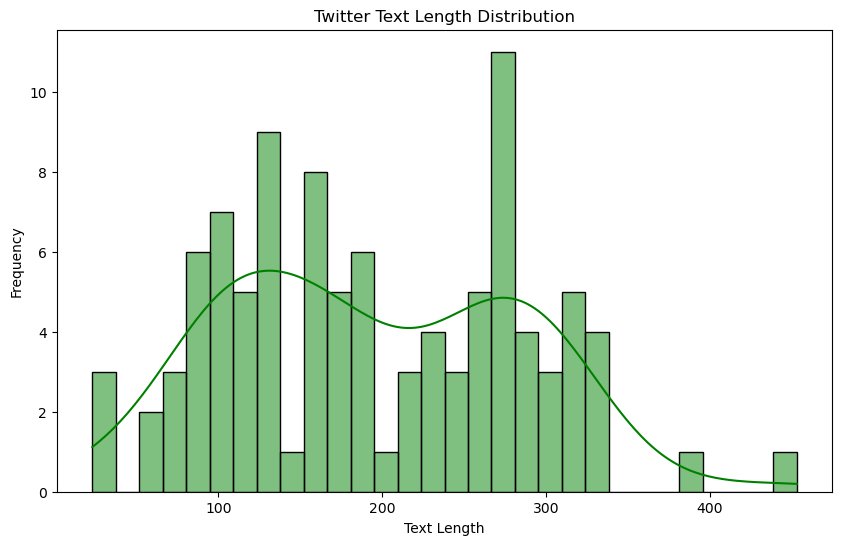

Visualization saved as reddit_text_length_distribution.png


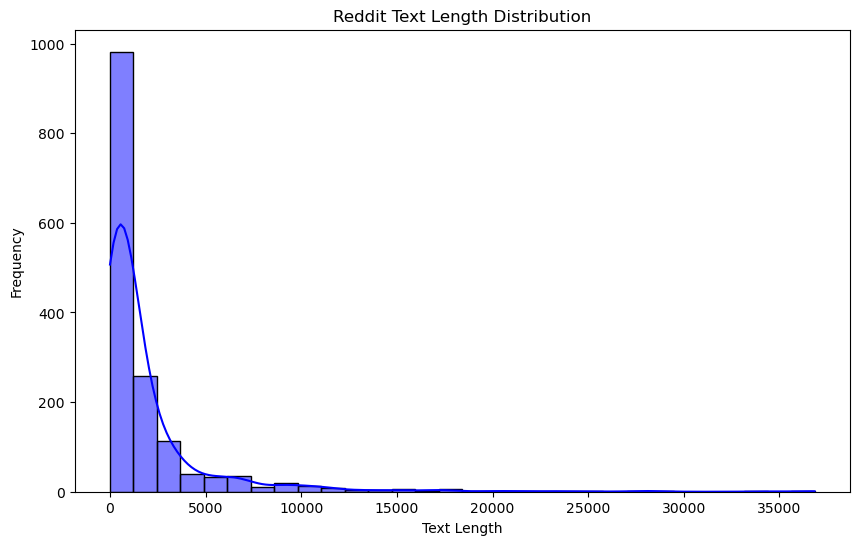

Visualization saved as youtube_text_length_distribution.png


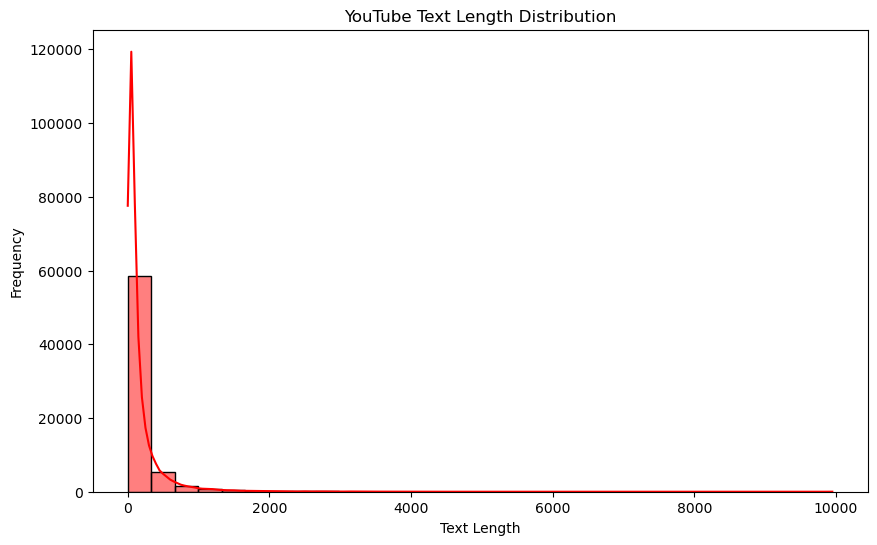

In [57]:
# Visualized text length distributions
def plot_text_length(df, text_column, name, color):
    df['text_length'] = df[text_column].astype(str).apply(len)
    plt.figure(figsize=(10, 6))
    sns.histplot(df['text_length'], kde=True, color=color, bins=30)
    plt.title(f"{name} Text Length Distribution")
    plt.xlabel("Text Length")
    plt.ylabel("Frequency")

    filename = f"{name.lower().replace(' ', '_')}_text_length_distribution.png"
    plt.savefig(filename, dpi=300, bbox_inches="tight") 
    print(f"Visualization saved as {filename}")
    
    plt.show()

plot_text_length(tweets, 'Text', "Twitter", "green")
plot_text_length(reddit, 'text', "Reddit", "blue")
plot_text_length(youtube, 'comment_text', "YouTube", "red")

## **Section 3: Data Cleaning**

To ensure consistency and accuracy, the datasets underwent rigorous cleaning. This included:
- Removing duplicates and irrelevant data points.
- Standardizing date formats across platforms.
- Handling missing or incomplete values to avoid skewed insights.
- Standardizing text strings before pre-processing.

In [71]:
# Loaded libraries
import numpy as np
import nltk
from textblob import TextBlob
from sklearn.preprocessing import LabelEncoder
from transformers import pipeline
import re
import string

In [163]:
# Imported clean CSVs
tweets = pd.read_csv("ai_movies_tweets.csv")
youtube = pd.read_csv("youtube_comments.csv")
reddit = pd.read_csv("reddit_posts.csv")

### **Twitter/X Data**

In [ ]:
# Converted column names to lowercase
tweets.columns = tweets.columns.str.lower()

# Cleaned 'text' column
tweets['text'] = (
    tweets['text']
    .str.lower()  
    .str.replace(r'@\w+', '', regex=True) 
    .str.replace(r'http\S+|www\S+', '', regex=True)  
    .str.replace(r'[^\w\s]', '', regex=True)
    .str.strip()
)

# Converted time column to datetime
tweets["created_at"] = pd.to_datetime(tweets["created_at"], utc=True)

# Removed duplicates
clean_tweets = tweets.copy()
clean_tweets = clean_tweets.drop_duplicates(subset=['text'])

# Saved cleaned data as CSV
clean_tweets.to_csv("clean_tweets.csv", index=False)
print(clean_tweets.head())

### **Reddit Data**

In [ ]:
# Cleaned text columns
def clean_text_column(df, column_name):
    df[column_name] = df[column_name].str.lower()
    df[column_name] = df[column_name].str.replace(r"http\S+|www\S+", "", regex=True)
    df[column_name] = df[column_name].str.replace(r"[^\w\s]", "", regex=True)
    df[column_name] = df[column_name].str.strip()
    return df

reddit = clean_text_column(reddit, "subreddit")
reddit = clean_text_column(reddit, "text")
reddit = clean_text_column(reddit, "title")

# Replaced null values
reddit.fillna({"title": "", "text": "", "subreddit": "", "created_at":"O"}, inplace=True)

# Standardized time column
reddit["created_at"] = pd.to_datetime(reddit["created_at"], errors='coerce', unit="s", utc=True)

# Removed duplicates
clean_reddit = reddit.copy()
clean_reddit.drop_duplicates(subset=['url', 'id'], keep='first', inplace=True)

# Saved cleaned data to CSV
clean_reddit.to_csv("clean_reddit.csv", index=False)
print(clean_reddit.head())

### **Youtube Data**

In [ ]:
# Standardized video title and comment text columns
def clean_and_standardize_text(text):
    if isinstance(text, str):
        text = text.lower() 
        text = re.sub(r"http\S+", "", text)
        text = re.sub(r"@\w+", "", text) 
        text = re.sub(r"#\w+", "", text)
        text = re.sub(r"[^a-z0-9\s,.!?'-]", "", text) 
        text = re.sub(r"\s+", " ", text)  
        text = text.strip()
    else:
        text = ""
    return text

youtube['video_title'] = youtube['video_title'].apply(clean_and_standardize_text)
youtube['comment_text'] = youtube['comment_text'].apply(clean_and_standardize_text)

# Standardized time columns
youtube['video_published_at'] = pd.to_datetime(youtube['video_published_at'], errors='coerce', utc=True)
youtube['comment_published_at'] = pd.to_datetime(youtube['comment_published_at'], errors='coerce', utc=True)

# Replaced null values
youtube['comment_text'] = youtube['comment_text'].fillna('')

# Removed duplicates
clean_youtube = youtube.drop_duplicates(subset=['comment_id'])

# Saved data to CSV
clean_youtube.to_csv("clean_youtube.csv", index=False)
print(clean_youtube.head())

### **Cleaning Verification**

Confirmed successful cleaning before moving on to analysis. Checked for:
- null values
- data types
- duplicates

In [171]:
clean_tweets = pd.read_csv("clean_tweets.csv")
clean_youtube = pd.read_csv("clean_youtube.csv")
clean_reddit = pd.read_csv("clean_reddit.csv")

In [ ]:
# Checked cleaning
def validate_data(df, platform_name):
    print(f"\nValidating data for {platform_name}:\n")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}\n")
    
    print("Null values per column:")
    print(df.isnull().sum(), "\n")
    print("Data types:")
    print(df.dtypes, "\n")
    duplicates = df.duplicated().sum()
    print(f"Duplicate rows: {duplicates}\n")
    print("Validation complete.")

validate_data(clean_tweets, "Twitter")
validate_data(clean_youtube, "YouTube")
validate_data(clean_reddit, "Reddit")

Then resolved any remaining errors missed or made during cleaning.

In [ ]:
# Converted dates to UTC
clean_reddit['created_at'] = pd.to_datetime(clean_reddit['created_at'], utc=True)
clean_tweets['created_at'] = pd.to_datetime(clean_tweets['created_at'], utc=True)
clean_youtube['comment_published_at'] = pd.to_datetime(clean_youtube['comment_published_at'], utc=True)
clean_youtube['video_published_at'] = pd.to_datetime(clean_youtube['video_published_at'], utc=True)
print(clean_reddit['created_at'].dtype)
print(clean_youtube['comment_published_at'].dtype)
print(clean_youtube['video_published_at'].dtype)
print(clean_tweets['created_at'].dtype)

# Resolved remaining nulls
clean_youtube['comment_text'] = clean_youtube['comment_text'].fillna('')
clean_tweets['text'] = clean_tweets['text'].fillna('')
clean_reddit['text'] = clean_reddit['text'].fillna('')
print(clean_youtube['comment_text'].isnull().sum())
print(clean_tweets['text'].isnull().sum())
print(clean_reddit['text'].isnull().sum())

# Resaved cleaned data
clean_reddit.to_csv("clean_reddit.csv", index=False)
clean_tweets.to_csv("clean_tweets.csv", index=False)
clean_youtube.to_csv("clean_youtube.csv", index=False)

## **Section 4: Data Pre-Processing**

Text pre-processing was essential for effective sentiment and emotion analysis. This stage involved:
- Tokenizing text and converting it to lowercase.
- Removing stopwords, punctuation, and non-alphabetical characters.
- Combining post title and comment text fields for Reddit to capture the full context of discussions.

The resulting processed text formed the basis for both sentiment polarity and emotion detection.

In [197]:
# Loaded libraries
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [199]:
# Loaded cleaned CSVs
ai_tweets = pd.read_csv("clean_tweets.csv")
ai_reddit = pd.read_csv("clean_reddit.csv")
ai_youtube = pd.read_csv("clean_youtube.csv")

In [201]:
# Pre-processing function
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    stop_words = set(stopwords.words("english"))
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if word not in string.punctuation]
    return " ".join(tokens)

# Applied function
ai_tweets['processed_text'] = ai_tweets['text'].apply(preprocess_text)
ai_reddit['processed_text'] = ai_reddit['text'].apply(preprocess_text)
ai_reddit['processed_title'] = ai_reddit['title'].apply(preprocess_text)
ai_youtube['processed_text'] = ai_youtube['comment_text'].apply(preprocess_text)

In [ ]:
# Combined Reddit columns
ai_reddit['processed_title'] = ai_reddit['processed_title'].where(
    ~ai_reddit.duplicated(subset=['processed_title']), ""
)
ai_reddit['combined_text'] = ai_reddit['processed_title'] + " " + ai_reddit['processed_text']
print(ai_reddit[['processed_title', 'processed_text', 'text']].head())

In [203]:
# Saved processed data
ai_reddit.to_csv("ai_reddit.csv", index=False)
ai_tweets.to_csv("ai_tweets.csv", index=False)
ai_youtube.to_csv("ai_youtube.csv", index=False)

## **Section 5: Sentiment Analysis**

This project employs three sentiment and emotion analysis methods:
1. **TextBlob**: A lightweight, rule-based method that calculates polarity and subjectivity. While simple, it provides consistent results for broad sentiment trends.
2. **Hugging Face Transformers**: A pre-trained deep learning model capable of capturing nuanced sentiments. The model used, `distilbert-base-uncased-finetuned-sst-2-english`, is fine-tuned for sentiment classification and offers more contextually-aware insights.
3. **NRC Emotion Lexicon (NRCLex)**: A lexicon-based tool that assigns text to one or more emotions (e.g., joy, fear, anger, trust) as well as positive or negative sentiment. It provides a deeper understanding of the emotional undertones in the data.

Combining these methods allows for complementary insights:
- **TextBlob** captures overall sentiment trends with simplicity.
- **Hugging Face Transformers** identifies nuanced patterns with modern deep-learning techniques.
- **NRC Lexicon** provides granular emotion-level analysis, offering a richer understanding of how people feel about AI.

In [ ]:
# Installed and loaded libraries
from sklearn.utils import resample
from textblob import TextBlob
!pip install torch
import torch
from transformers import pipeline
import matplotlib.dates as mdates

In [207]:
# Loaded CSVs
ai_tweets = pd.read_csv("ai_tweets.csv")
ai_reddit = pd.read_csv("ai_reddit.csv")
ai_youtube = pd.read_csv("ai_youtube.csv")

### **Data Normalization**

To ensure fair comparison, the datasets were normalized by downsampling the Youtube dataset to match the size of the Reddit data. While there is still significantly less data from X, this prevents Youtube from dominating the analysis. Normalization was applied using stratified sampling to preserve the sentiment distribution within Youtube data.

In [211]:
# Downsampled YouTube data to match Reddit data size
reddit_sample_size = len(ai_reddit)
ai_youtube_normalized = resample(ai_youtube, n_samples=reddit_sample_size, random_state=42)

# Checked sizes
print(f"Reddit data size: {len(ai_reddit)}")
print(f"Normalized YouTube data size: {len(ai_youtube_normalized)}")

Reddit data size: 1539
Normalized YouTube data size: 1539


### **Sentiment Analysis Using TextBlob**

In [213]:
# Function to calculate sentiment polarity
def calculate_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return 0
    return TextBlob(text).sentiment.polarity

# Applied sentiment analysis to each dataset
ai_tweets['sentiment'] = ai_tweets['processed_text'].apply(calculate_sentiment)
ai_reddit['sentiment'] = ai_reddit['combined_text'].apply(calculate_sentiment)
ai_youtube_normalized['sentiment'] = ai_youtube_normalized['processed_text'].apply(calculate_sentiment)

# Printed sentiment summaries
print("Sentiment Summary for Tweets:\n", ai_tweets['sentiment'].describe())
print("Sentiment Summary for Reddit:\n", ai_reddit['sentiment'].describe())
print("Sentiment Summary for YouTube:\n", ai_youtube_normalized['sentiment'].describe())

Sentiment Summary for Tweets:
 count    92.000000
mean      0.093032
std       0.253725
min      -1.000000
25%       0.000000
50%       0.078899
75%       0.213750
max       1.000000
Name: sentiment, dtype: float64
Sentiment Summary for Reddit:
 count    1539.000000
mean        0.113835
std         0.154204
min        -0.700000
25%         0.000000
50%         0.110440
75%         0.191688
max         1.000000
Name: sentiment, dtype: float64
Sentiment Summary for YouTube:
 count    1539.000000
mean        0.075528
std         0.296036
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.202358
max         1.000000
Name: sentiment, dtype: float64


### **Sentiment Analysis Using Huggling Face Transformers**

In [215]:
# Initialized Hugging Face sentiment analysis pipeline
model_name = "distilbert-base-uncased-finetuned-sst-2-english"  # Default model
sentiment_analyzer = pipeline("sentiment-analysis", model=model_name)

# Function to get sentiment from Hugging Face
def transformer_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return {"label": "NEUTRAL", "score": 0.0}
    try:
        result = sentiment_analyzer(text[:512])  # Limit text to 512 characters
        return result[0]
    except Exception as e:
        print(f"Error analyzing text: {text[:50]}... - {e}")
        return {"label": "NEUTRAL", "score": 0.0}

# Applied Hugging Face sentiment analysis to each dataset
ai_tweets['transformer_sentiment'] = ai_tweets['processed_text'].map(transformer_sentiment)
ai_reddit['transformer_sentiment'] = ai_reddit['combined_text'].map(transformer_sentiment)
ai_youtube_normalized['transformer_sentiment'] = ai_youtube_normalized['processed_text'].map(transformer_sentiment)

# Extracted label and score for analysis
def extract_label(sentiment):
    return sentiment['label']

def extract_score(sentiment):
    return sentiment['score']

ai_tweets['transformer_label'] = ai_tweets['transformer_sentiment'].map(extract_label)
ai_tweets['transformer_score'] = ai_tweets['transformer_sentiment'].map(extract_score)

ai_reddit['transformer_label'] = ai_reddit['transformer_sentiment'].map(extract_label)
ai_reddit['transformer_score'] = ai_reddit['transformer_sentiment'].map(extract_score)

ai_youtube_normalized['transformer_label'] = ai_youtube_normalized['transformer_sentiment'].map(extract_label)
ai_youtube_normalized['transformer_score'] = ai_youtube_normalized['transformer_sentiment'].map(extract_score)

# Printed summaries
print("Hugging Face Sentiment Summary for Tweets:\n", ai_tweets['transformer_label'].value_counts())
print("Hugging Face Sentiment Summary for Reddit:\n", ai_reddit['transformer_label'].value_counts())
print("Hugging Face Sentiment Summary for YouTube:\n", ai_youtube_normalized['transformer_label'].value_counts())

Hugging Face Sentiment Summary for Tweets:
 transformer_label
NEGATIVE    59
POSITIVE    32
NEUTRAL      1
Name: count, dtype: int64
Hugging Face Sentiment Summary for Reddit:
 transformer_label
NEGATIVE    1070
POSITIVE     459
NEUTRAL       10
Name: count, dtype: int64
Hugging Face Sentiment Summary for YouTube:
 transformer_label
NEGATIVE    924
POSITIVE    587
NEUTRAL      28
Name: count, dtype: int64


In [216]:
# Saved results to CSV
ai_tweets.to_csv("ai_tweets_sentiment.csv", index=False)
ai_reddit.to_csv("ai_reddit_sentiment.csv", index=False)
ai_youtube_normalized.to_csv("ai_youtube_sentiment.csv", index=False)

### **Sentiment Visualizations**

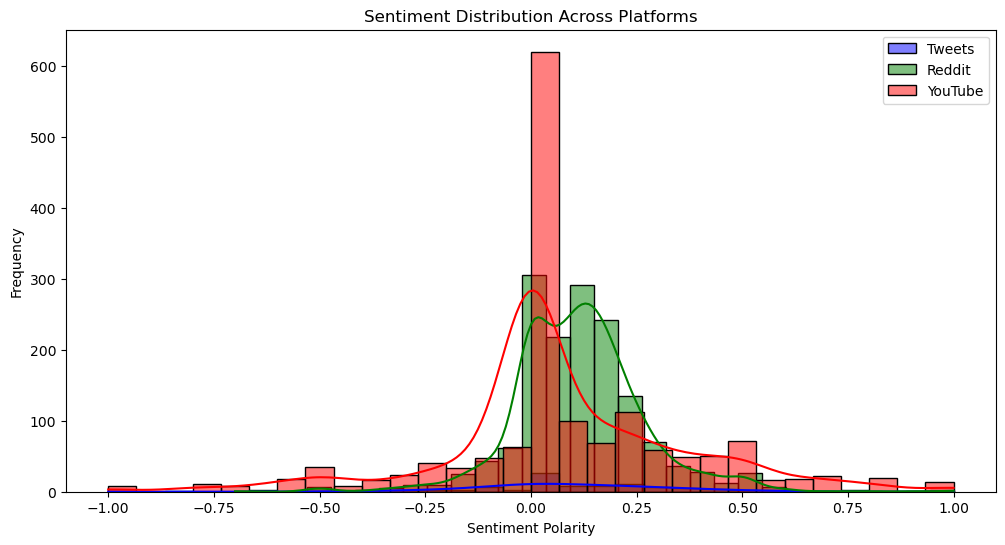

In [217]:
# Plot sentiment distributions
plt.figure(figsize=(12, 6))
sns.histplot(ai_tweets['sentiment'], bins=30, kde=True, color="blue", label="Tweets")
sns.histplot(ai_reddit['sentiment'], bins=30, kde=True, color="green", label="Reddit")
sns.histplot(ai_youtube_normalized['sentiment'], bins=30, kde=True, color="red", label="YouTube")
plt.legend()
plt.title("Sentiment Distribution Across Platforms")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Frequency")
plt.savefig("sentiment_distributions.png", dpi=300, bbox_inches="tight")
plt.show()

The scatter plots below show sentiment polarity over time for Reddit, YouTube, and Twitter. Each point represents an individual comment or post, with the y-axis showing sentiment polarity:
- Positive values indicate positive sentiment.
- Negative values indicate negative sentiment.

By comparing the platforms, we can observe variations in sentiment trends over time.

Saved: reddit_sentiment.png
Saved: twitter_sentiment.png
Saved: youtube_sentiment.png
Saved: combined_sentiment_trends.png


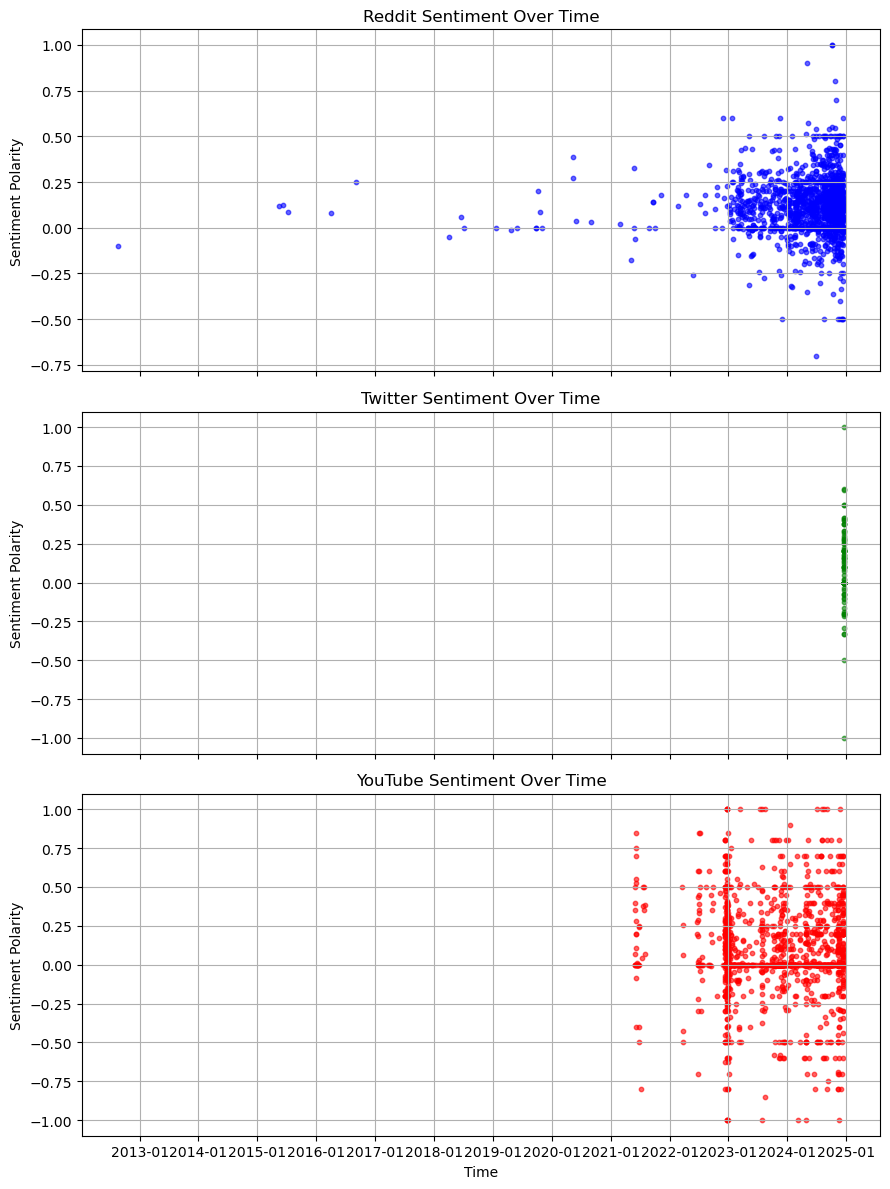

In [232]:
# Function to generate and save individual plots
def plot_and_save_sentiment(x, y, title, filename, color, alpha=0.6, s=10):
    plt.figure(figsize=(9, 4))
    plt.scatter(x, y, color=color, alpha=alpha, s=s)
    plt.title(title)
    plt.ylabel("Sentiment Polarity")
    plt.xlabel("Time")
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    print(f"Saved: {filename}")
    plt.close()

platforms = [
    {"data": ai_reddit, "x": "created_at", "y": "sentiment", 
     "title": "Reddit Sentiment Over Time", "filename": "reddit_sentiment.png", "color": "blue"},
    {"data": ai_tweets, "x": "created_at", "y": "sentiment", 
     "title": "Twitter Sentiment Over Time", "filename": "twitter_sentiment.png", "color": "green"},
    {"data": ai_youtube_normalized, "x": "comment_published_at", "y": "sentiment", 
     "title": "YouTube Sentiment Over Time", "filename": "youtube_sentiment.png", "color": "red"}
]
# Indiviual plots
for platform in platforms:
    plot_and_save_sentiment(
        x=platform["data"][platform["x"]], 
        y=platform["data"][platform["y"]], 
        title=platform["title"], 
        filename=platform["filename"], 
        color=platform["color"]
    )

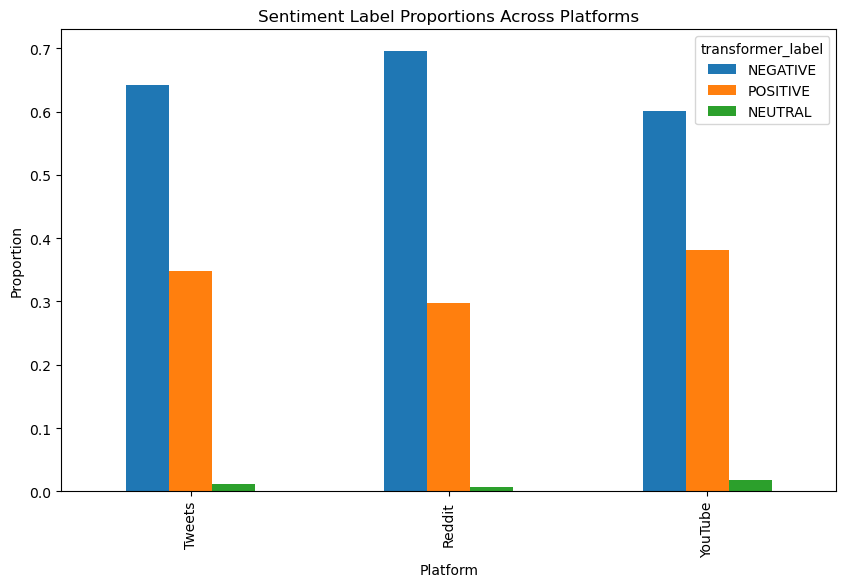

In [236]:
# Plot sentiment label proportions
sentiment_labels = pd.DataFrame({
    "Tweets": ai_tweets['transformer_label'].value_counts(normalize=True),
    "Reddit": ai_reddit['transformer_label'].value_counts(normalize=True),
    "YouTube": ai_youtube_normalized['transformer_label'].value_counts(normalize=True)
}).T

sentiment_labels.plot(kind='bar', figsize=(10, 6))
plt.title("Sentiment Label Proportions Across Platforms")
plt.xlabel("Platform")
plt.ylabel("Proportion")
plt.savefig("sentiment_proportions.png", dpi=300, bbox_inches="tight")
plt.show()

### **Interpreting Sentiment Analysis Results**

This phase of sentiment analysis used both TextBlob and Hugging Face Transformers to extract sentiment (positive, negative, neutral) from the text. While both methods provide insights, they employ different approaches which yield different results.

1. TextBlob: May not capture nuances of contextual language but provides consistent, lightweight results.
2. Hugging Face Transformers: Better at contextualizing sentiment based on modern text but may reflect biases from training data.

**Discrepancies in Results**

The analysis reveals a divergence between the two methods:

- TextBlob tends to classify most text as neutral or mildly positive due to its simple scoring mechanism. These results show much less polarity than Hugging Face.
- Hugging Face Transformers identifies more distinct sentiment boundaries, especially for strongly polarized text.

## **Section 6: Emotion Analysis Using NRC Lexicon**

The initial sentiment analysis using TextBlob and Hugging Face Transformers revealed diverging results across platforms, highlighting the limitations of traditional sentiment polarity scores. While TextBlob provided a high-level overview of positivity, negativity, and neutrality, and Hugging Face Transformers added a layer of nuance, neither approach fully captured the emotional complexity present in discussions about AI in filmmaking and media creation.

To gain a deeper understanding, this section uses the NRC Emotion Lexicon (NRCLex) to assign emotions such as joy, trust, fear, sadness, and others to the processed text. By analyzing emotions, the goal is to uncover the underlying feelings behind the sentiments and explore how they differ across platforms. This deeper analysis provides insights into the emotional landscape of AI’s role in creative storytelling, moving beyond simple sentiment polarity to uncover the nuances of public perception.

**The results of this emotional breakdown will help address questions such as:**

- Which emotions dominate the conversation on each platform?
- Are discussions about AI in media creation driven more by excitement or fear?
- How do these emotional trends align with or diverge from the initial sentiment analysis?
- By combining sentiment polarity with emotion detection, this analysis aims to present a richer, multidimensional view of public discourse.

In [238]:
# Imported and loaded libraries
!pip install nrclex
!pip install transformers
from nrclex import NRCLex

In [ ]:
# Function to extract emotion scores
def extract_emotions(text):
    if not isinstance(text, str) or not text.strip():
        return {emotion: 0 for emotion in ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']}
    emotions = NRCLex(text).affect_frequencies
    return {emotion: emotions.get(emotion, 0) for emotion in ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']}

# Applied emotion analysis to all datasets
emotion_columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']

for dataset, name in zip(
    [ai_tweets, ai_reddit, ai_youtube_normalized],
    ['Twitter', 'Reddit', 'YouTube']
):
    emotions_df = dataset['processed_text'].apply(extract_emotions).apply(pd.Series)
    emotions_df.columns = emotion_columns
    dataset[emotion_columns] = emotions_df
    print(f"Emotion analysis completed for {name}.")

In [242]:
# Summarized emotions for Twitter
emotion_summary_twitter = ai_tweets[emotion_columns].sum().sort_values(ascending=False)
print("\nEmotion Summary for Twitter:")
print(emotion_summary_twitter)

# Summarized emotions for YouTube
emotion_summary_youtube = ai_youtube_normalized[emotion_columns].sum().sort_values(ascending=False)
print("\nEmotion Summary for YouTube:")
print(emotion_summary_youtube)

# Summarized emotions for Reddit
emotion_summary_reddit = ai_reddit[emotion_columns].sum().sort_values(ascending=False)
print("\nEmotion Summary for Reddit:")
print(emotion_summary_reddit)


Emotion Summary for Twitter:
anticipation    11.047193
trust            8.282003
joy              7.658280
fear             5.574517
surprise         4.669553
sadness          3.753336
anger            3.244372
disgust          2.597745
dtype: float64

Emotion Summary for YouTube:
anticipation    124.680911
trust           118.259340
joy              95.970612
sadness          75.256343
fear             72.534979
surprise         54.497009
anger            54.225961
disgust          40.824223
dtype: float64

Emotion Summary for Reddit:
trust           195.838671
anticipation    140.502923
joy             127.556984
fear             63.454879
sadness          55.210835
surprise         51.287519
anger            42.293984
disgust          28.564980
dtype: float64


### **Emotion Visualization**

In [244]:
# Installed and loaded word cloud library
!pip install wordcloud
from wordcloud import WordCloud

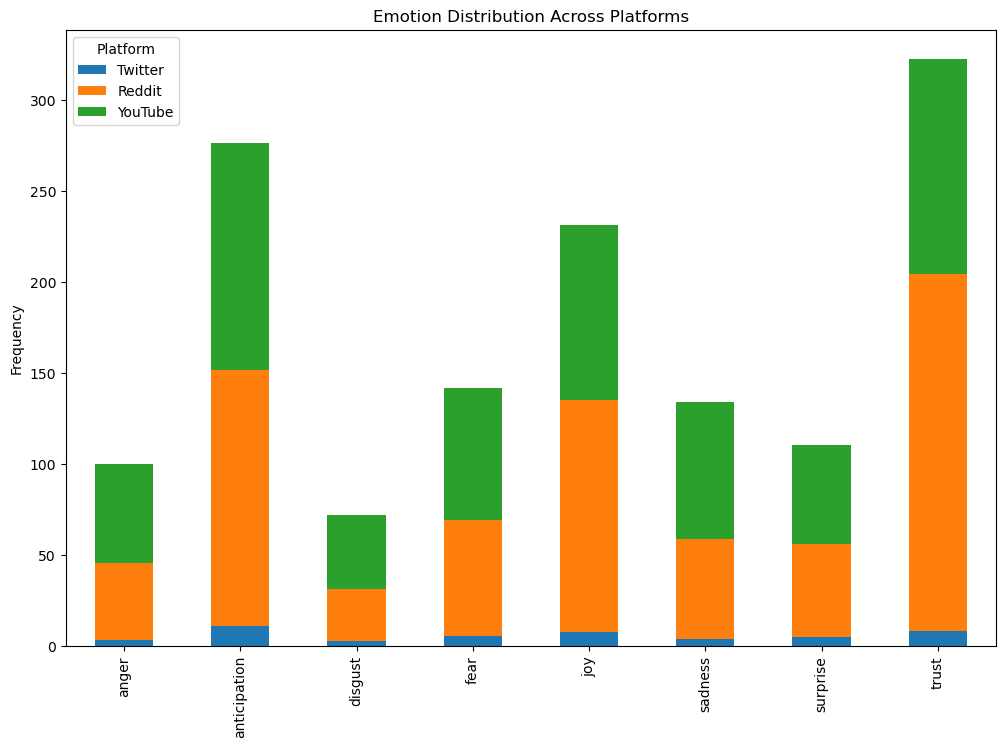

In [246]:
# Aggregated and visualized emotion distributions
emotion_summary = pd.DataFrame({
    "Platform": ["Twitter", "Reddit", "YouTube"],
    **{
        emotion: [
            ai_tweets[emotion].sum(),
            ai_reddit[emotion].sum(),
            ai_youtube_normalized[emotion].sum()
        ]
        for emotion in emotion_columns
    }
})

# Plotted emotion distributions
emotion_summary.set_index("Platform").T.plot(kind="bar", figsize=(12, 8), stacked=True)
plt.title("Emotion Distribution Across Platforms")
plt.ylabel("Frequency")
plt.savefig("emotion_distributions.png", dpi=300, bbox_inches="tight")
plt.show()

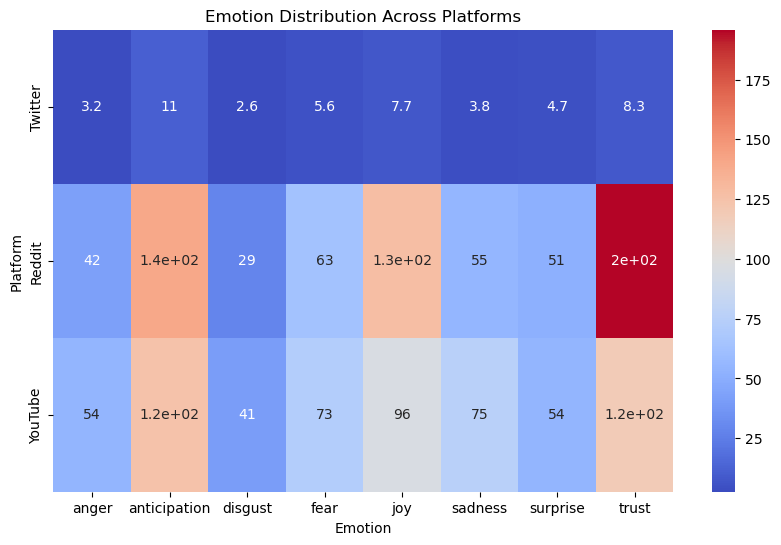

In [248]:
# Aggregated emotions
emotion_columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']
emotion_summary = pd.DataFrame({
    "Twitter": ai_tweets[emotion_columns].sum(),
    "Reddit": ai_reddit[emotion_columns].sum(),
    "YouTube": ai_youtube_normalized[emotion_columns].sum()
}).T

# Plotted heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(emotion_summary, annot=True, cmap='coolwarm', cbar=True)
plt.title("Emotion Distribution Across Platforms")
plt.xlabel("Emotion")
plt.ylabel("Platform")
plt.savefig("emotion_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

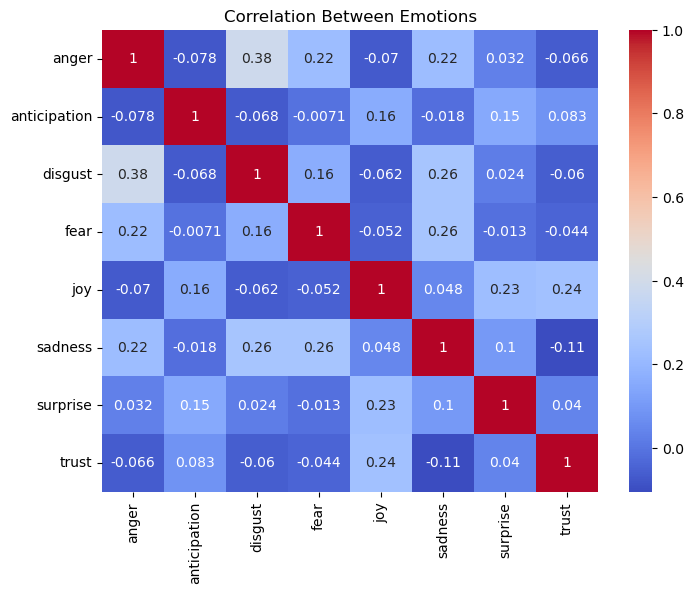

In [250]:
# Combined emotion columns from all platforms
combined_emotions = pd.concat([
    ai_tweets[emotion_columns],
    ai_reddit[emotion_columns],
    ai_youtube_normalized[emotion_columns]
])

# Calculate correlation
correlation_matrix = combined_emotions.corr()

# Plotted heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", cbar=True)
plt.title("Correlation Between Emotions")
plt.savefig("emotion_correlations.png", dpi=300, bbox_inches="tight")
plt.show()

### **Word Cloud Creation**

Saved: twitter_wordcloud.png


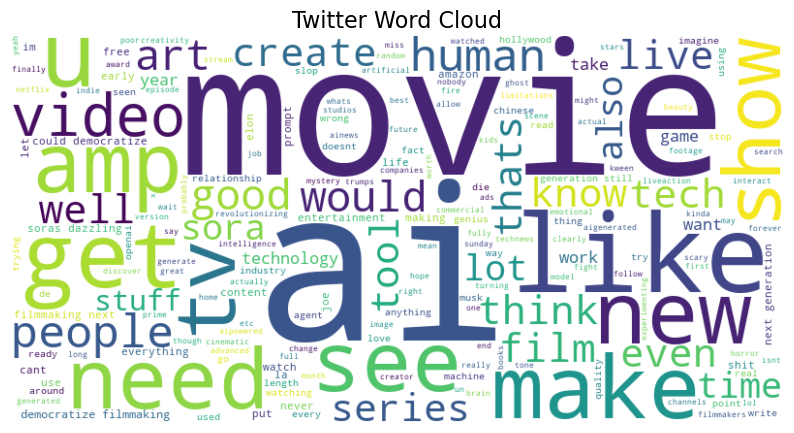

Saved: reddit_wordcloud.png


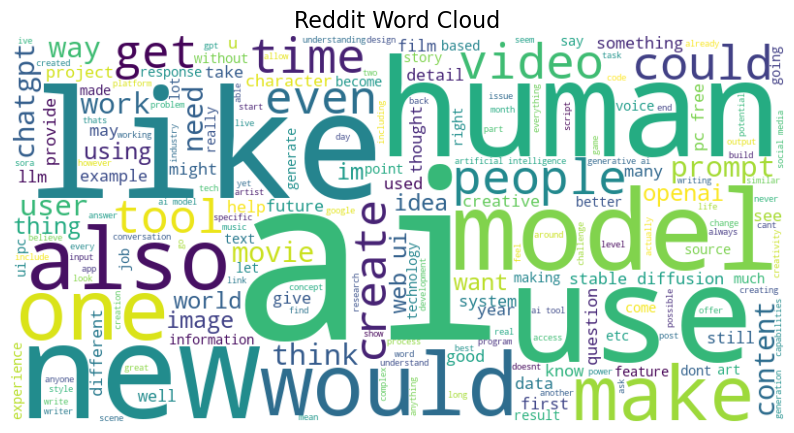

Saved: youtube_wordcloud.png


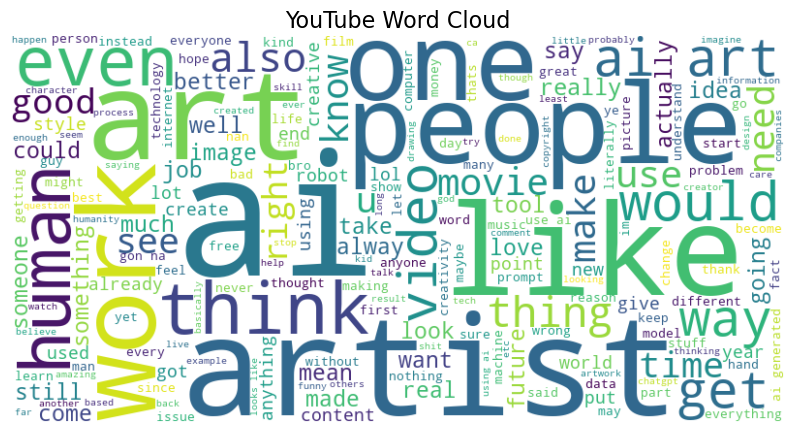

In [256]:
def generate_word_cloud(df, text_column, title, filename):
    text = " ".join(str(row) for row in df[text_column])  # Combine all text
    stop_words = set(stopwords.words('english'))  # Stopwords
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white', 
        stopwords=stop_words, 
        colormap='viridis'
    ).generate(text)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    print(f"Saved: {filename}")
    
    plt.show()

# Generated word clouds for each platform
generate_word_cloud(ai_tweets, 'processed_text', "Twitter Word Cloud", "twitter_wordcloud.png")
generate_word_cloud(ai_reddit, 'combined_text', "Reddit Word Cloud", "reddit_wordcloud.png")
generate_word_cloud(ai_youtube, 'processed_text', "YouTube Word Cloud", "youtube_wordcloud.png")

### **Word Frequency Exploration**

In [259]:
from collections import Counter
from nltk.tokenize import word_tokenize

In [261]:
# Function to compute word frequencies
def common_words(df, text_column, num_words=30):
    text = " ".join(str(row) for row in df[text_column])
    stop_words = set(stopwords.words('english'))
    tokens = [word.lower() for word in word_tokenize(text) if word.isalpha() and word not in stop_words]
    word_freq = Counter(tokens).most_common(num_words)
    return pd.DataFrame(word_freq, columns=["Word", "Frequency"])

# Displayed top 30 words for each platform
print("--- Common Words in Twitter ---")
print(common_words(ai_tweets, 'processed_text'))

print("--- Common Words in Reddit ---")
print(common_words(ai_reddit, 'combined_text'))

print("--- Common Words in YouTube ---")
print(common_words(ai_youtube, 'processed_text'))

--- Common Words in Twitter ---
          Word  Frequency
0           ai         94
1       movies         77
2         like         15
3          get         11
4           us         10
5        movie          9
6         make          9
7           tv          9
8          see          9
9          amp          9
10         new          8
11  filmmaking          7
12       would          7
13        good          7
14      people          7
15      create          6
16        well          6
17        need          6
18       shows          6
19       thats          6
20       video          6
21         art          6
22        next          6
23  generation          6
24       think          6
25        even          6
26        tech          6
27      series          6
28        sora          5
29        also          5
--- Common Words in Reddit ---
       Word  Frequency
0        ai       5164
1      like       1545
2       new       1022
3       use        982
4     would     

## **Section 7: Summary of Insights from Sentiment and Emotion Analysis**

### **Emotion Trends Across Platforms**

1. Twitter:
- Sentiment on Twitter was predominantly neutral, as identified by TextBlob, reflecting broad, generalized opinions about AI in creative media.
- Positive sentiment was primarily driven by excitement about AI's potential to streamline creative workflows and enhance production efficiency.
- Emotion analysis with NRCLex revealed that anticipation and trust were the dominant emotions, showcasing curiosity and cautious optimism about AI's role in media.
- Fear and joy also emerged as significant, indicating mixed reactions ranging from hopeful excitement to apprehensive skepticism.
- Negative emotions like anger and disgust were observed at much lower frequencies, reinforcing Twitter's role as a platform for balanced, surface-level discussions.

2. YouTube:

- YouTube exhibited the highest emotional engagement across platforms, likely due to its diverse, visual content and broader audience reach.
- Positive emotions like joy, trust, and anticipation were dominant, reflecting widespread enthusiasm for AI’s capabilities, particularly in creative tools such as automated video editing, visual effects, and generative content.
- However, fear also appeared significantly, indicating concerns about AI’s long-term impact on creative authenticity and employment.
- Negative emotions like anger and sadness were present but less prevalent than positive emotions, likely diluted by the platform’s generally optimistic tone.
- The emotional balance on YouTube highlights both excitement about AI’s transformative potential and caution about its implications.

3. Reddit:
- Discussions on Reddit leaned heavily toward fear and skepticism, reflecting a more critical and debate-driven audience.
- While trust and anticipation were present, they appeared at relatively lower levels compared to YouTube, indicating a more tempered outlook.
- Prominent negative emotions like fear and sadness reveal underlying concerns about the ethical implications of AI, its impact on creativity, and the potential loss of human involvement in storytelling.
- Reddit's role as a forum for in-depth discussions allowed for nuanced, often polarizing conversations that explored both the promises and risks of AI in creative industries.

### **Sentiment Divergence**

The two sentiment analysis models—TextBlob and Hugging Face Transformers—produced differing results, underscoring the complexity of the sentiment landscape:

1. TextBlob:
- Predominantly neutral and mildly positive sentiments, reflecting a simplified, rule-based classification.
- While effective for capturing broad trends, TextBlob struggled to identify strong polarities or emotional nuances in the text.

2. Hugging Face Transformers:
- Revealed sharper sentiment distinctions, with negative sentiment dominating across platforms.
- The model captured stronger emotional reactions, such as fear and skepticism, but may have overemphasized extremes due to biases in its training dataset.

### **Key Findings**

The combined analysis of sentiment and emotions reveals a nuanced and polarized conversation about AI in film and media creation:

**Mixed Reactions to AI:**

Positive emotions—trust, anticipation, and joy—reflect excitement about AI’s ability to enhance creative tools, improve efficiency, and enable new storytelling possibilities.
Negative sentiments and emotions—fear, anger, and sadness—highlight concerns about ethical dilemmas, loss of authenticity, and disruptions to traditional creative roles.

**Platform-Specific Insights:**

YouTube users demonstrate a more optimistic and engaged response, driven by exposure to practical applications and examples of AI’s capabilities.
Reddit users engage in more critical, detailed discussions, often focusing on the risks and challenges of AI in creative industries.
Twitter captures a broad, neutral sentiment with occasional optimism, serving as a platform for generalized commentary and surface-level discussions.

**A Polarized Landscape:**

The results highlight the inherent tension between excitement for AI’s creative potential and skepticism about its long-term consequences.
While platforms like YouTube reveal higher positivity and trust, Reddit and Transformers-based sentiment analysis bring critical perspectives to light, balancing the narrative.

## **Section 8: Limitations**

While this project provides valuable insights, several limitations should be noted:

1. **Data Volume Imbalance**: Twitter data was limited to 100 tweets due to API restrictions, whereas Reddit and YouTube had significantly larger datasets.
2. **Keyword-Based Search**: Using keywords like 'AI' and 'filmmaking' may have excluded relevant discussions with different phrasing.
3. **Sentiment Model Limitations**: TextBlob neutralizes sentiment, while Transformers may amplify extreme scores. Emotion detection may miss nuances like sarcasm.

## **Section 9: Future Work/Recommendations**

1. **Expand Data Sources**: Incorporate platforms like TikTok or Instagram to analyze visually creative communities.
2. **Topic Modeling**: Use techniques like Latent Dirichlet Allocation (LDA) to identify dominant themes and link them to emotions.
3. **Longitudinal Analysis**: Analyze sentiment and emotion trends over extended periods to track changes in perceptions.
4. **Advanced Sentiment Models**: Use fine-tuned models specifically trained on creative content discussions for greater accuracy.